<a href="https://colab.research.google.com/github/rvraghvender/DeepLearningProjects/blob/main/ConvolutionNeuralNetworks/ConvolutionNeuralNetworksApplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 - TensorFlow model

Utilize the programming frameworks to perform convolution neural networks operations.

In [282]:
# import relevant packages
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [283]:
print(tf.__version__)

2.12.0


In [284]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")

    # train set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])  # train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    # test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])  # test set labels

    classes = np.array(test_dataset["list_classes"][:])  # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [285]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [286]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :, :, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = math.floor(m / mini_batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: m, :, :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size: m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [287]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 0


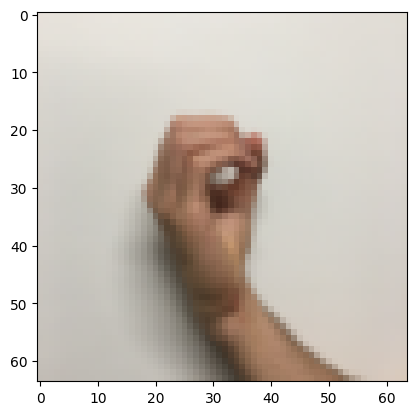

In [296]:
# Example of picture
index = 124
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [289]:
# Exploring the dataset

# Normalizing the dataset
X_train = X_train_orig/255.0
X_test = X_test_orig/255.0

# Converting Y labels to one-hot vectors
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## Creating Placeholders for the TensorFlow framework

Tensorflow framework requires to create placeholders for the input data that will be fed into the model when running the session.

In [290]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    '''
    Creates the placeholders for the tensorflow session.

    Args:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    '''
    tf.compat.v1.disable_eager_execution()


    X = tf.compat.v1.placeholder(shape=[None, n_H0, n_W0, n_C0], dtype="float", name="X")
    Y = tf.compat.v1.placeholder(shape=[None, n_y], dtype="float", name="Y")

    return X, Y

## Initialize parameters
Initialize the weights/filters $W1$ and $W2$ using ```tf.contrib.layer.xavier_initializer(seed = 0).```.
Tensorflow automatically takes care of bias variable. Moreover, in the beginning we only to initialize the ```conv2d``` function as Tensorflow automatically initializes the fully connected layer.

In [291]:
def initialize_parameters():
    '''
    Initializes weight parameters to build a neural network with tensorflow:

    The shapes are :
                W1 : [4, 4, 3, 8]
                W2 : [2, 2, 8, 16]

    Returns:
    parameters -- a dictionary of tensor containing W1, W2
    '''
    tf.random.set_seed(1)

    # W1 = tf.Variable("W1", [4, 4, 3, 8], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed = 0))
    # W2 = tf.Variable("W2", [2, 2, 8, 16], initializer = tf.compat.v1.keras.initializers.glorot_normal(seed = 0))

    # normal_var = tf.Variable(tf.glorot_uniform_initializer()((3, 3)))


    W1 = tf.Variable(tf.compat.v1.keras.initializers.glorot_normal(seed = 0)((4, 4, 3, 8)))

    W2 = tf.Variable(tf.compat.v1.keras.initializers.glorot_normal(seed = 0)((2, 2, 8, 16)))

    parameters = {
        "W1" : W1,
        "W2" : W2
                  }

    return parameters


## Forward propagation

In Tensorflow, thre are builit-in functions that implement the convolution steps.

*   ```tf.nn.conv2d(X, W, strides = [1,s,s,1], padding = 'SAME')```: given an input X and a group of filters $W$, this functions convolves $W$'s filters on $X$. The third parameter ```[1,s,s,1]``` represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). Normally, a choice of stride 1 for the number of examples (the first value) and for the channels (the fourth values)

*  ```tf.nn.max_pool(A, ksize=[1,f,f,1], strides=[1,s,s,1], padding = 'SAME')```: given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out the max pooling over each window. For max pooling, we usually operate on a single example and a single channel at a time. So the first and the fourth value in ```[1, f, f, 1]``` are both 1.

*  ```tf.nn.relu(Z)```: computes the elementwise ReLU of Z.

*  ```tf.contrib.layers.flatten(P)```: given a tensor "P", this function takes each training (or test) example in the batch and flattens it into a 1D vector.

    1. If a tensor P has the shape (m,h,w,c), where m is the number of examples (the batch size), it returns a flattened tensor with shape (batch_size, k), where $k=h \times w \times c$.  "k" equals the product of all the dimension sizes other than the first dimension.
    2. For example, given a tensor with dimensions [100,2,3,4], it flattens the tensor to be of shape [100, 24], where 24=2 * 3 * 4.
*   ```tf.contrib.fully_connected(F, num_outputs)```: given the flattened input F, it returns the output computed using a fully connected layer. Here the weights are automatically initialized in the fully connected layer in the graphs and keeps on training them as we train the model.

### Window, kernel, filter

The words "window", "kernel" and "filter" are used to refer to the same thing.
---------------------------------------------------------<br>

Implement the `forward_propagation` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`.

In detail, we will use the following parameters for all the steps:
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - Flatten the previous output.
 - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost.

In [292]:
def forward_propagation(X, parameters):
    '''
    Implement the forward propagation for the model:

    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input datset placeholder, of shape (input_size, number of examples)
    parameteres -- python dictionary containing parameters "W1", and "W2".

    Returns:
    Z3 -- the output of the last LINEAR unit.
    '''

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    W2 = parameters['W2']

    # CONV2D: stride of 1, padding 'SAME'
    s = 1
    Z1 = tf.nn.conv2d(X, W1, strides=[1, s, s, 1], padding='SAME')

    # ReLU
    A1 = tf.nn.relu(Z1)

    # Maxpooling with window 8x8, stride 8, padding 'SAME'
    f = 8
    s = 8
    P1 = tf.nn.max_pool(A1, ksize = [1, f, f, 1], strides = [1, s, s, 1], padding='SAME')

    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, s, s, 1], padding='SAME')

    # ReLU
    A2 = tf.nn.relu(Z2)

    # Maxpooling with window 4x4, stride 4, padding 'SAME'
    f = 4
    s = 4
    P2 = tf.nn.max_pool(A2, ksize=[1,f,f,1], strides=[1,s,s,1], padding='SAME')

    # FLATTEN
    F = tf.compat.v1.layers.flatten(P2)

    # Fully-connected without non-linear activation function.
    # 6 neuron in the output layer.
    num_outputs = 6
    Z3 = tf.compat.v1.layers.dense(F, num_outputs, activation=None)

    return Z3

## Compute cost
Implement the compute cost function. This function tells the neural network how much the model's predictions differ from the correct labels. By adjusting the weights of the network to reduce the cost, the neural network can improve its predictions.

**Helpful functions**
*    ```tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y)```: computes the softmax entropy loss. This function computes the softmax activation function as well as resulting loss.
*    ```tf.reduce_mean```: computes the mean of elements across dimensions of tensor. It is used to calculate the sum of the losses over all the examples to get the overall cost.


#### Details on softmax_cross_entropy_with_logits
* Softmax is used to format outputs so that they can be used for classification.  It assigns a value between 0 and 1 for each category, where the sum of all prediction values (across all possible categories) equals 1.
* Cross Entropy is compares the model's predicted classifications with the actual labels and results in a numerical value representing the "loss" of the model's predictions.
* "Logits" are the result of multiplying the weights and adding the biases.  Logits are passed through an activation function (such as a relu), and the result is called the "activation."
* The function is named `softmax_cross_entropy_with_logits` takes logits as input (and not activations); then uses the model to predict using softmax, and then compares the predictions with the true labels using cross entropy.  These are done with a single function to optimize the calculations.

In [293]:
def compute_cost(Z3, Y):
    '''
    Computes the cost

    Args:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost  -- Tensor of the cost function
    '''

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))

    return cost

## Model
Build a function to implement training the dataset.

Implement
-   Create placeholder
-   initialize parameters
-   forward propagate
-   compute the cost
-   create an optimizer

### Adam Optimizer

```tf.train.AdamOptimizer(learning_rate=...)```: This function is used to create the optimizer. The optimizer has a minimize(loss=...) function that is called to set the cost function that the optimizer will minimize.

### Random mini batches

This function returns a list of mini-batches.
```Python
minibatches = random_mini_batches(X, Y, mini_batch_size = 64, seed = 0)
```

### Evaluating the optimizer and cost
Within a loop, for each mini-batch, `tf.Session` object (named `sess`) is used to feed a mini-batch of inputs and labels into the neural network and evaluate the tensors for the optimizer as well as the cost.

  The graph data structure and need to feed it inputs and labels and use `sess.run()` in order to get values for the optimizer and cost.

```
output_for_var1, output_for_var2 = sess.run(
                                                fetches=[var1, var2],
                                                feed_dict={var_inputs: the_batch_of_inputs,
                                                           var_labels: the_batch_of_labels}
                                                )
```
* Notice that `sess.run` takes its first argument `fetches` as a list of objects that you want it to evaluate (in this case, we want to evaluate the optimizer and the cost).
* It also takes a dictionary for the `feed_dict` parameter.
* The keys are the `tf.placeholder` variables that we created in the `create_placeholders` function above.
* The values are the variables holding the actual numpy arrays for each mini-batch.
* The sess.run outputs a tuple of the evaluated tensors, in the same order as the list given to `fetches`.

In [294]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables

    tf.random.set_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []                                        # To keep track of the cost

    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()

    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.optimizers.Adam(learning_rate = learning_rate).minimize(loss=cost, var_list = None, tape=None)

    # Initialize all the variables globally
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})

                minibatch_cost += temp_cost / num_minibatches


            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)


        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy, test_accuracy, parameters

In [295]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

<ipython-input-292-7dde8f732c42>:43: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  F = tf.compat.v1.layers.flatten(P2)
<ipython-input-292-7dde8f732c42>:48: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Z3 = tf.compat.v1.layers.dense(F, num_outputs, activation=None)


ValueError: ignored